In [24]:
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter, ImageOps
import matplotlib.pyplot as plt
import pandas as pd
import easyocr
reader = easyocr.Reader(['ko'])  # 'ko'는 한국어를 위해, 'en'은 영어를 위해

# Function to display image using matplotlib
def show_image(img, title="Image"):
    plt.figure(figsize=(10, 6))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def process_image_turn(image_path, file):
    img = Image.open(image_path)
    # show_image(img)
    
       # padding 해줘서 돌릴 때 짤리지 않게
    img = ImageOps.expand(img, border=100, fill='white')
    # show_image(img)
    img = np.array(img)  # Convert the PIL image to a NumPy array
    
    ##################### rotate
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Find lines using HoughLines
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

    if lines is None:
        return pd.DataFrame(columns=['ID', 'OCR', 'target'])

    # Calculate the angle of the skew
    angles = []
    for line in lines:
        rho, theta = line[0]
        angle = np.degrees(theta) - 90
        angles.append(angle)


    # Compute the median angle
    median_angle = np.median(angles)

    # Rotate the image to correct the skew if necessary
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)

    # print(median_angle)
    if abs(median_angle) > 12.0:  # Adjust this threshold as necessary
        M = cv2.getRotationMatrix2D(center, median_angle, 1.0)
        rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    else:
        rotated = img  # Use the original image if no rotation is needed

    

    all_results = []

    # Convert back to PIL image to display
    rotated_pil = Image.fromarray(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
    
    
    
    gray_image = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    average_brightness = np.mean(gray_image)
    # print(average_brightness)
    if average_brightness<160:
        # 밝기 조절
        enhancer = ImageEnhance.Brightness(rotated_pil)
        rotated_pil = enhancer.enhance(2.0)  # 밝기를 증가, 이것보다 높게 하면 자동회전이 잘못되서 위치 바꿈

        # 대비 조절
        enhancer = ImageEnhance.Contrast(rotated_pil)
        rotated_pil = enhancer.enhance(3.0)  # 대비를 증가, 이것보다 높게 하면 자동회전이 잘못되서 위치 바꿈
    

    def process_and_append(image, description):
        #print(description)
        # show_image(image)
        df = process_image_with_ocr(image, file)
        #print(df['OCR'])
        if not df.empty:
            print('*****************',file)
            # print(description, df['OCR'], df['target'])
            all_results.append(df)
            return True
        return False

    if process_and_append(rotated_pil, "rotated_pil"):
        return all_results
    
    rotated_270 = rotated_pil.rotate(270, expand=True)
    if process_and_append(rotated_270, "rotated_270"):
        return all_results
    
    rotated_180 = rotated_pil.rotate(180, expand=True)
    if process_and_append(rotated_180, "rotated_180"):
        return all_results
    
    rotated_90 = rotated_pil.rotate(90, expand=True)
    if process_and_append(rotated_90, "rotated_90"):
        return all_results
    
    

    mirrored_pil1 = ImageOps.mirror(rotated_pil)
    if process_and_append(mirrored_pil1, "mirrored_pil1"):
        return all_results
    
    mirrored_rotated_270 = mirrored_pil1.rotate(270, expand=True)
    if process_and_append(mirrored_rotated_270, "mirrored_rotated_270"):
        return all_results
    
    mirrored_rotated_180 = mirrored_pil1.rotate(180, expand=True)
    if process_and_append(mirrored_rotated_180, "mirrored_rotated_180"):
        return all_results
    
    mirrored_rotated_90 = mirrored_pil1.rotate(90, expand=True)
    if process_and_append(mirrored_rotated_90, "mirrored_rotated_90"):
        return all_results


    return all_results

# Function to process an image with OCR
def process_image_with_ocr(img, image_name):
    if img is None:
        return pd.DataFrame(columns=['ID', 'OCR', 'target'])

    image_width = img.width  # 이미지의 전체 너비
    image_height = img.height  # 이미지의 전체 높이
    crop_height = image_height // 3  # 이미지 높이의 1/5

    crop_area = (0, 0, image_width, crop_height)
    img_cropped = img.crop(crop_area)

    # Convert the cropped image to a format suitable for OpenCV
    # img = np.array(img)
    # img_cv = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    img_cropped = np.array(img_cropped)
    img_cropped_cv = cv2.cvtColor(img_cropped, cv2.COLOR_RGB2BGR)
    img_cropped_cv = cv2.cvtColor(img_cropped_cv, cv2.COLOR_BGR2GRAY)
    img_cropped_cv = cv2.fastNlMeansDenoising(img_cropped_cv, h=3)
    
    # show_image(img_cropped_cv)
    
    # EasyOCR로 텍스트 추출
    # results1 = reader.readtext(img_cv, detail=0)  # detail=0 returns only text
    # extracted_text1 = ' '.join(results1).replace(" ", "")
    # print(extracted_text1)
    
    # EasyOCR로 텍스트 추출
    results2 = reader.readtext(img_cropped_cv, detail=0)  # detail=0 returns only text
    extracted_text2 = ' '.join(results2).replace(" ", "")
    # print(extracted_text2)

  
    
    
    # 7,3 에 대해서만 판단하는 것이 맞는 듯. submission 94% 정확도가 올라가면 pytesseract ocr 정확도가 따라가지 못함. 
    keywords_4 = ['진단서','전단서']
    keywords_5= ['운전면허증']
    keywords_7 = ['통원','동원','진료확인서']
    keywords_10 = ['납입','남입','남임','남원','입확인서','임확인서','입확원서','임확원서','임화인서']
    keywords_3 = ['입원','퇴원','원확인서','완확원서','완확원서']
    keywords_8= ['주민등록증','주민등록중']
    keywords_9= ['대한민국','여권']    
    keywords_11= ['약제비계산서영수증','영수증','복약','조제약']
    keywords_13= ['이력서','자소서']
    keywords_14 = ['소견서']
    keywords_15= ['자동차등록증','자동차등록중','자동자등록증']
    keywords_12= ['처방전','처방']
    keywords_1= ['건강보험','임신','출산']
    keywords_6 = ['외래', '계산서']
    
    keywords_dict = {
        
        # 순서가 중요!!!! ocr에 검출되는 단어들이 중복되서 나오기 때문.
        4: keywords_4,
        5: keywords_5,
        
        7: keywords_7,
        10: keywords_10,
        3: keywords_3,
        8: keywords_8,
        9: keywords_9,
        
        11: keywords_11,
        
        13: keywords_13,
        14: keywords_14,
        15: keywords_15,
        12: keywords_12,
        1: keywords_1,
        6: keywords_6,
    }

    
    matched_results = []
    for number, keywords in keywords_dict.items():
        if any(keyword in extracted_text2 for keyword in keywords):
            matched_results.append((image_name, extracted_text2, number))
            break
        # elif any(keyword in extracted_text1 for keyword in keywords):
        #     matched_results.append((image_name, extracted_text1, number))
        #     break

    df = pd.DataFrame(matched_results, columns=['ID', 'OCR', 'target'])
    return df

pd.set_option('display.max_colwidth', None)

# Function to process all images in a directory
def process_directory(directory):
    all_results = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(root, file)
                results = process_image_turn(image_path, file)
                if len(results) > 0:
                    all_results.extend(results)
                              
    if all_results:
        final_df = pd.concat(all_results, ignore_index=True)
    else:
        final_df = pd.DataFrame(columns=['ID', 'OCR', 'target'])
    return final_df


# 특정 디렉토리 테스트용
# Directory containing the images
# directory = '/data/ephemeral/home/datasets_fin/ocr_test3'

# # Process all images in the directory
# result_df = process_directory(directory)

# # Save the result to a CSV file
# #result_df.to_csv(r'/data/ephemeral/home/notebook/ocr_output_3_7.csv', index=False)

# # Display the final result DataFrame
# print("Final Result DataFrame:")
# print(result_df)



# 다른 submission과 ensemble 작업할 때 사용
output = pd.read_csv(r'/data/ephemeral/home/notebook/output_0.9514.csv')
filtered_ids = output[(output['target'].isin([3,4,7,14]))]['ID']
print(len(filtered_ids))



# 디렉토리 내 이미지를 처리
def process_directory2(directory, valid_ids):
    all_results = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file in valid_ids.values:
                image_path = os.path.join(root, file)
                # print("Processing:", image_path)  # 경로 확인용 출력
                results = process_image_turn(image_path, file)  # 각 파일에 대해 이미지 처리 함수 호출
                if len(results) > 0:
                    all_results.extend(results)  # 결과 합치기

    if all_results:
        final_df = pd.concat(all_results, ignore_index=True)
    else:
        final_df = pd.DataFrame(columns=['ID', 'OCR', 'target'])
    return final_df


# 이미지 처리
directory = '/data/ephemeral/home/datasets_fin/test'
final_df = process_directory2(directory, filtered_ids)
final_df.to_csv(r'/data/ephemeral/home/notebook/ocr_output_9514_34714.csv', index=False)

print(final_df)


693
***************** 10b350a87c7fc903.jpg
***************** 457d4a0ed1647ebb.jpg
***************** 2788f05973ca8a3c.jpg
***************** 8538d5326f92f9fb.jpg
***************** f95c84c901644f43.jpg
***************** 8979f2734e1e5f33.jpg
***************** aa0fe3d7687790c5.jpg
***************** af00c00738a9da9f.jpg
***************** b2a1a2dc8491cd35.jpg
***************** 4e462fe22a88b7c9.jpg
***************** afa31e08d4f6249c.jpg
***************** 5a79e12b2b95d779.jpg
***************** 1638d8b30b2a013e.jpg
***************** e7f2c8600531b584.jpg
***************** 15d6890b32a3491a.jpg
***************** 6d1bd13a90451337.jpg
***************** caa807ca79e17e92.jpg
***************** cb3179f4bfdf1878.jpg
***************** 90ca3b055765dc7f.jpg
***************** d2a9e0d2faa42d67.jpg
***************** 5d778edcf3564010.jpg
***************** f830778e8769f032.jpg
***************** 8412f8a036a5d120.jpg
***************** 781f87e2ec698df4.jpg
***************** a1a719520384a188.jpg
***************** 563

In [25]:
print(len(filtered_ids))

693


In [26]:
import pandas as pd

pred_df = pd.read_csv("/data/ephemeral/home/notebook/output_0.9514.csv")
ocr_df = pd.read_csv("/data/ephemeral/home/notebook/ocr_output_9514_34714.csv")

merged_df = pred_df.merge(ocr_df[['ID', 'target']], on='ID', how='left', suffixes=('', '_ocr'))

# # target 값 대체 (replace)
merged_df['target'] = merged_df['target_ocr'].combine_first(merged_df['target'])

# # 필요 없는 'target_ocr' 컬럼 삭제
merged_df2 = merged_df.drop(columns=['target_ocr'])

# # 결과 저장
merged_df2.to_csv("/data/ephemeral/home/notebook/EASY_pred_ocr_0806_9514_34714.csv", index=False)

In [44]:
output_hardvoting = pd.read_csv(r'/data/ephemeral/home/notebook/output_hardvoting.csv')
print(pred_df.equals(output_hardvoting)) 

True


In [27]:
output_hardvoting = pd.read_csv("/data/ephemeral/home/notebook/output_0.9514.csv")
EASY_pred_ocr_0806_34714 = pd.read_csv("/data/ephemeral/home/notebook/EASY_pred_ocr_0806_9514_34714.csv")

df = pd.merge(output_hardvoting, EASY_pred_ocr_0806_34714, on='ID', how='left', suffixes=('', '_me'))
df[df['target']!=df['target_me']]
len(df[df['target']!=df['target_me']])

64

In [29]:
pd.set_option('display.max_rows',None) 
df[df['target']!=df['target_me']]

,ID,target,target_me
54,0546cab14c4ee65b.jpg,4,7.0
83,082e8c4d8d82eb01.jpg,7,3.0
185,106e817be539b3e7.jpg,7,3.0
217,12c0ac56836761e0.jpg,7,3.0
251,15ca73556389df7e.jpg,7,3.0
253,15d6890b32a3491a.jpg,7,3.0
271,17ab20ba9372dfc0.jpg,7,3.0
281,18912bd404188282.jpg,7,3.0
293,19715393750c278b.jpg,7,3.0
310,1b45268518d29b07.jpg,7,3.0


Macro F1 Score: 0.9970102202682587


/tmp/ipykernel_1005260/2312908032.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_labels, fontsize=10) # fontproperties=font_prop,
/tmp/ipykernel_1005260/2312908032.py:73: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1005260/2312908032.py:73: UserWarning: Glyph 51340 (\N{HANGUL SYLLABLE JWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1005260/2312908032.py:73: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1005260/2312908032.py:73: UserWarning: Glyph 54840 (\N{HANGUL SYLLABLE HO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1005260/2312908032.py:73: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_10052

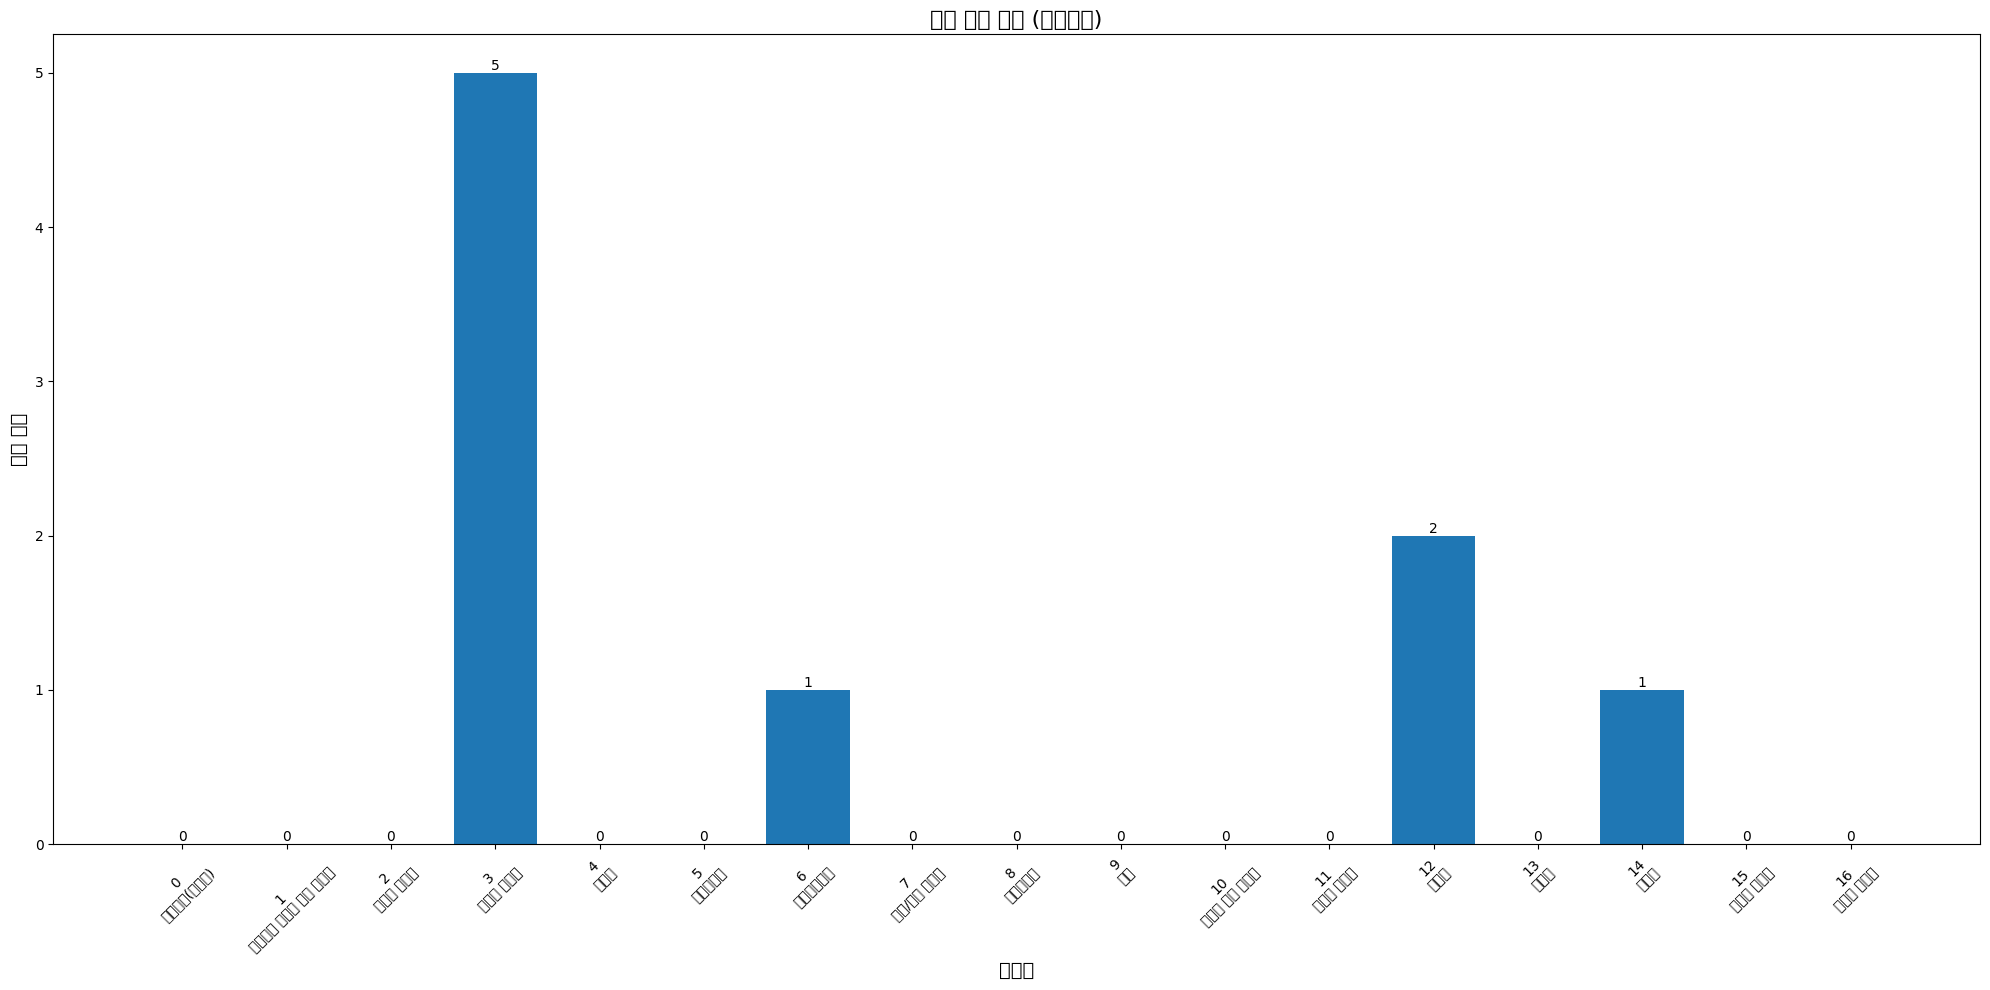

/tmp/ipykernel_1005260/2312908032.py:139: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1005260/2312908032.py:139: UserWarning: Glyph 45813 (\N{HANGUL SYLLABLE DAB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1005260/2312908032.py:139: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1005260/2312908032.py:139: UserWarning: Glyph 53748 (\N{HANGUL SYLLABLE TOE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1005260/2312908032.py:139: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1005260/2312908032.py:139: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1005260/2312908032.py:139: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font

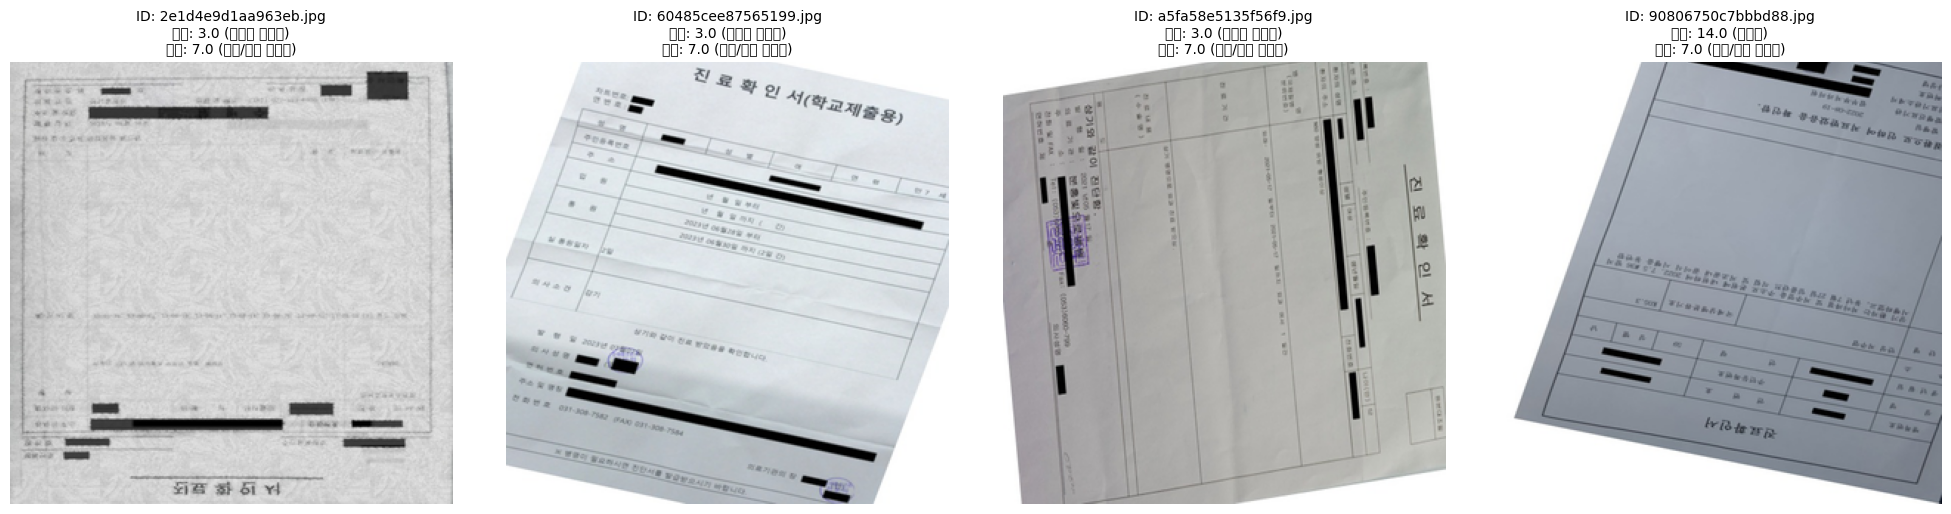

총 4개의 이미지가 표시되었습니다.


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.metrics import f1_score
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties


def load_predictions(file_paths):
    """여러 모델의 예측 결과를 로드합니다."""
    predictions = {}
    for path in file_paths:
        model_name = os.path.basename(path).split('.')[0]
        df = pd.read_csv(path)
        # ID 컬럼 중복 제거 및 예측 컬럼 이름 변경
        df = df[['ID', 'target']].rename(columns={'target': model_name})
        predictions[model_name] = df
    return predictions

def find_different_predictions(predictions):
    """모든 모델에서 다르게 예측한 항목을 찾습니다."""
    # 모든 예측을 하나의 DataFrame으로 병합
    all_predictions = predictions[list(predictions.keys())[0]]
    for model, df in list(predictions.items())[1:]:
        all_predictions = pd.merge(all_predictions, df, on='ID', suffixes=('', f'_{model}'))
    
    # 예측 컬럼만 선택
    prediction_columns = [col for col in all_predictions.columns if col != 'ID']
    
    # 예측이 다른 행만 선택
    different_predictions = all_predictions[all_predictions[prediction_columns].nunique(axis=1) > 1]
    return different_predictions

def calculate_macro_f1(ground_truth, predictions):
    """Macro F1 점수를 계산합니다."""
    return f1_score(ground_truth, predictions, average='macro')

def plot_error_distribution(ground_truth, predictions):
    """각 클래스별 오류 예측 개수를 bar plot으로 표시합니다."""
    # 클래스 이름 정의
    class_names = {
        0: "계좌번호(손글씨)", 1: "임신출산 진료비 지급 신청서", 2: "자동차 계기판", 3: "입퇴원 확인서", 4: "진단서", 
        5: "운전면허증", 6: "진료비영수증", 7: "통원/진료 확인서", 8: "주민등록증", 9: "여권", 
        10: "진료비 납입 확인서", 11: "약제비 영수증", 12: "처방전", 13: "이력서", 14: "소견서", 
        15: "자동차 등록증", 16: "자동차 번호판"
    }

    error_counts = {i: 0 for i in range(len(class_names))}  # 모든 클래스에 대해 초기화
    for gt, pred in zip(ground_truth, predictions):
        if gt != pred:
            error_counts[gt] += 1
    
    classes = sorted(error_counts.keys())
    counts = [error_counts[c] for c in classes]
    class_labels = [f"{c}\n{class_names[c]}" for c in classes]
    
    # 나눔 폰트 설정
    # font_path = './font/NanumGothic.otf'
    # font_prop = FontProperties(fname=font_path)
    
    plt.figure(figsize=(20, 10))
    bars = plt.bar(class_labels, counts)
    plt.title("오류 예측 개수 (클래스별)", fontsize=16)# fontproperties=font_prop, 
    plt.xlabel("클래스", fontsize=14)# fontproperties=font_prop, 
    plt.ylabel("오류 개수", fontsize=14)# fontproperties=font_prop, 
    plt.xticks(rotation=45, ha='center')
    
    # x축 레이블에 폰트 적용
    ax = plt.gca()
    ax.set_xticklabels(class_labels, fontsize=10) # fontproperties=font_prop, 
    
    plt.tight_layout()
    
    # 각 막대 위에 값 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}',
                 ha='center', va='bottom')# fontproperties=font_prop, 
    
    plt.show()  
    
    
def display_images_and_predictions(different_predictions, image_dir, ground_truth_name, prediction_name, class_filter=None, max_images_per_class=3):
    """다르게 예측된 항목의 이미지와 예측 결과를 표시합니다."""
    # 나눔 폰트 설정
    # font_path = './font/NanumGothic.otf'
    # font_prop = FontProperties(fname=font_path)
    class_names = {
        0: "계좌번호(손글씨)", 1: "임신출산 진료비 지급 신청서", 2: "자동차 계기판", 3: "입퇴원 확인서", 4: "진단서", 
        5: "운전면허증", 6: "진료비영수증", 7: "통원/진료 확인서", 8: "주민등록증", 9: "여권", 
        10: "진료비 납입 확인서", 11: "약제비 영수증", 12: "처방전", 13: "이력서", 14: "소견서", 
        15: "자동차 등록증", 16: "자동차 번호판"
    }
    
    # 클래스별로 이미지 분류
    class_images = {c: [] for c in range(len(class_names))}
    for idx, row in different_predictions.iterrows():
        ground_truth = row[ground_truth_name]
        if class_filter is None or ground_truth in class_filter:
            class_images[ground_truth].append(row)
    
    # 표시할 이미지 선택
    images_to_display = []
    for c, imgs in class_images.items():
        if class_filter is None or c in class_filter:
            images_to_display.extend(imgs[:max_images_per_class])
    
    # 이미지 표시
    num_images = len(images_to_display)
    rows = (num_images - 1) // 4 + 1
    fig, axs = plt.subplots(rows, 4, figsize=(20, 5*rows))
    
    for i, row in enumerate(images_to_display):
        ax = axs[i//4, i%4] if rows > 1 else axs[i%4]
        
        image_id = row['ID']
        ground_truth = row[ground_truth_name]
        prediction = row[prediction_name]
        image_path = os.path.join(image_dir, image_id)
        
        if os.path.exists(image_path):
            img = Image.open(image_path)
            img = img.resize((300, 300), Image.LANCZOS)
            ax.imshow(img)
            ax.axis('off')
            id = f"ID: {image_id}"
            comparison_text = f"정답: {ground_truth} ({class_names[ground_truth]})\n예측: {prediction} ({class_names[prediction]})"
            ax.set_title(f"{id}\n{comparison_text}", fontsize=10) # fontproperties=font_prop, 
        else:
            ax.text(0.5, 0.5, f"Image not found\nfor ID: {image_id}", ha='center', va='center')
    
    # 빈 서브플롯 제거
    for i in range(num_images, rows*4):
        ax = axs[i//4, i%4] if rows > 1 else axs[i%4]
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"총 {num_images}개의 이미지가 표시되었습니다.")    

# 예측 파일 경로
file_paths = [
    "/data/ephemeral/home/notebook/EASY_pred_ocr_0805_34714.csv",
    "/data/ephemeral/home/notebook/EASY_pred_ocr_0806_13471214.csv",
]


# 이미지 디렉토리 경로
image_dir = "/data/ephemeral/home/datasets_fin/test"

# 예측 로드
predictions = load_predictions(file_paths)

# 다른 예측 찾기
different_predictions = find_different_predictions(predictions)

# # 결과 출력
# print(different_predictions)

# Macro F1 점수 계산
ground_truth_name = os.path.basename(file_paths[0]).split('.')[0]
prediction_name = os.path.basename(file_paths[-1]).split('.')[0]
ground_truth = predictions[ground_truth_name][ground_truth_name]
prediction = predictions[prediction_name][prediction_name]
macro_f1 = calculate_macro_f1(ground_truth, prediction)
print(f"Macro F1 Score: {macro_f1}")

# 오류 분포 그래프 표시
plot_error_distribution(ground_truth, prediction)


# 특정 클래스(예: 0, 1, 2)에 대해 클래스당 최대 3개씩 이미지 표시
display_images_and_predictions(different_predictions, image_dir, ground_truth_name, prediction_name, class_filter=[3, 7, 14], max_images_per_class=3)

In [5]:
pred_df = pd.read_csv("/data/ephemeral/home/notebook/output.csv")
ocr_output_3_7 = pd.read_csv("/data/ephemeral/home/notebook/ocr_output_3_7.csv")
ocr_output_4_14 = pd.read_csv("/data/ephemeral/home/notebook/ocr_output_4_14.csv")


merged_df3 = pred_df.merge(ocr_output_3_7[['ID', 'target']], on='ID', how='left', suffixes=('', '3_7_ocr'))
merged_df4 = merged_df3.merge(ocr_output_4_14[['ID', 'target']], on='ID', how='left', suffixes=('', '4_14_ocr'))

In [6]:
merged_df4

,ID,target,target3_7_ocr,target4_14_ocr
0,0008fdb22ddce0ce.jpg,2,NaN,NaN
1,00091bffdffd83de.jpg,12,NaN,NaN
2,00396fbc1f6cc21d.jpg,5,NaN,NaN
3,00471f8038d9c4b6.jpg,12,NaN,NaN
4,00901f504008d884.jpg,2,NaN,NaN
...,...,...,...,...
3135,ffb4b6f619fb60ea.jpg,6,NaN,NaN
3136,ffb54299b1ad4159.jpg,10,NaN,NaN
3137,ffc2c91dff8cf2c0.jpg,8,NaN,NaN
3138,ffc4e330a5353a2a.jpg,0,NaN,NaN


In [8]:
df = merged_df4[merged_df4['target4_14_ocr'].isna()==False]
df[df['target']!=df['target4_14_ocr']]

,ID,target,target3_7_ocr,target4_14_ocr
451,2788f05973ca8a3c.jpg,4,NaN,7.0
679,39c97e8c3e07a970.jpg,4,NaN,3.0
1322,6e87683611244cc9.jpg,14,NaN,4.0
1581,845d51149dd90a37.jpg,14,NaN,3.0
1909,9e95f18106634063.jpg,4,NaN,3.0
2029,a89b258856f1e224.jpg,4,NaN,6.0
2323,bed3afcc44c426c3.jpg,14,NaN,4.0
2334,c05bdf0dfc422bf0.jpg,4,NaN,7.0
2349,c21908abd08920af.jpg,4,NaN,3.0
